## Imports

In [99]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from typing import List
from statsmodels.tsa.seasonal import seasonal_decompose

# Importing functions from src/data
parent_dir = os.path.abspath(os.path.join('..'))
module_path = parent_dir + "/src/data"

if module_path not in sys.path:
    sys.path.append(module_path)

import database as db
import api
import helpers as pkle
import constants as cnt

## Table of Contents

1. [Data Collection](#data-collection)
2. [Data Validation](#data-validation)
3. [Preprocessing](#preprocessing)
4. [Time Series Characteristics](#time-series-characteristics)
5. [Modeling](#modeling)

### Data Collection

The average price is collected from an API and stored in a postgresql database. In order to retrieve the data in order to begin any analysis we make a query to the database which is handled by the market_data function below.

The data recieved is in the format of a list of 3-tuples containing a unique id, time and price at that time.

In [84]:
# TODO: Improve function to follow dry principles, remove the depedency of raw_material_name and market_data
def create_item_dataframe(raw_material_name: str, region_id: str | int = "0"):
    """ Dataframe constructed from the stats of a material and region id. Will contain stats like
    sell and buy weighted Average, median, min, max, stddev and order counts.

    Args:
        raw_material_name (str): Name of the material
        region_id (str | int, optional): The region id that associates with one of the regions in Eve Online. Defaults to "0".

    Returns:
        Dataframe: Contains all stats for a particular material
    """
    
    # TODO: fix the repetitive code below
    # Historical average buy and sell order stats for raw_material_name
    buy_market_stats = api.market_data(raw_material_name, region_id=region_id)
    buy_order_stats = [i[2] for i in buy_market_stats]
    times = [i[1] for i in buy_market_stats]
    
    sell_market_stats = api.market_data(raw_material_name, region_id=region_id, order_type="sell")
    sell_order_stats = [i[2] for i in sell_market_stats]
    times = [i[1] for i in sell_market_stats]

    # Creating dataframe for buy and sell orders and renaming columns
    df_buy = pd.DataFrame(data=buy_order_stats)
    df_buy.rename(columns=lambda x: "buy_" + x, inplace=True)
    
    df_sell = pd.DataFrame(data=sell_order_stats)
    df_sell.rename(columns=lambda x: "sell_" + x, inplace=True)
    
    df_times = pd.DataFrame(data=times, columns=["time"])

    df = pd.concat([df_times, df_buy, df_sell], axis=1)
    
    # Fixing datatype for all the columns except the time column
    for i in df.iloc[:,1:].columns:
        df[i] = pd.to_numeric(df[i])

    return df

def plot_timeseries(raw_material_name, df, cols):
    df = df[cols]
    data = pd.melt(df, ["time"])
        
    # Plot
    sns.set_theme(style="white")
    fig = sns.lineplot(data=data, x='time', y='value', hue='variable')
    fig.set(title=f"The Price of {raw_material_name}", ylabel="Price (ISK)")
    fig.lines[0].set_linestyle("--")
    plt.xticks(rotation=90)

def create_item_plot(raw_material_name: str, region_id: str = "0", cols: List[str]=['time', 'sell_weightedAverage']):
    
    df = create_item_dataframe(raw_material_name, region_id=region_id)
    
    if 'time' not in cols:
        cols.append('time')
        
    plot_timeseries(raw_material_name, df, cols)
    

We will be constructing a dataframe that contains various statistics. There are two features we are mostly considered with sell_weightedAverage and sell_median. However in order to avoid any really high or low sell prices that may portray a unrealistic price to sell the materials at. We will use the weightedAverage as it mitages the bias of those trying to sell for very high or for very low.



In [85]:
# Overview of the data for Chiral Structures
chiral_structures = create_item_dataframe("Chiral Structures", "30000142")
chiral_structures

Command executed successfully
Command executed successfully


,time,buy_weightedAverage,buy_max,buy_min,buy_stddev,buy_median,buy_volume,buy_orderCount,buy_percentile,sell_weightedAverage,sell_max,sell_min,sell_stddev,sell_median,sell_volume,sell_orderCount,sell_percentile
0,2022-05-23 17:43:39.687705,162.526178,490.3,5.53,201.787541,397.6,778909.0,8,490.300000,588.445816,870.0,539.9,96.790840,602.5,8043694.0,34,539.974052
1,2022-05-23 17:51:28.883474,162.526178,490.3,5.53,201.787541,397.6,778909.0,8,490.300000,588.472990,870.0,539.9,96.790840,602.5,8039194.0,34,539.975157
2,2022-05-23 17:53:37.915917,162.526178,490.3,5.53,201.787541,397.6,778909.0,8,490.300000,588.472990,870.0,539.9,96.790840,602.5,8039194.0,34,539.975157
3,2022-05-23 17:56:09.959608,162.526178,490.3,5.53,201.787541,397.6,778909.0,8,490.300000,588.472990,870.0,539.9,96.790840,602.5,8039194.0,34,539.975157
4,2022-05-23 18:00:37.138196,162.526178,490.3,5.53,201.787541,397.6,778909.0,8,490.300000,588.472990,870.0,539.9,96.790840,602.5,8039194.0,34,539.975157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,2022-06-10 20:00:39.885346,361.431159,483.4,5.53,174.682577,476.1,2040170.0,13,483.335134,605.860707,747.7,533.4,71.094613,602.6,3221338.0,25,533.432961
394,2022-06-10 21:00:39.246107,361.727476,483.9,5.53,174.764581,476.1,2040170.0,13,483.835134,606.620336,747.7,533.4,71.094613,602.6,3187918.0,25,533.453225
395,2022-06-10 22:00:41.924547,360.275513,484.3,5.53,174.781987,476.1,2016170.0,13,483.858725,611.587769,747.7,533.5,70.412684,603.8,2985219.0,24,533.955122
396,2022-06-10 23:00:40.779917,359.665323,483.9,5.53,180.313858,473.6,2004330.0,12,483.900000,612.472574,747.7,534.0,69.460422,605.0,2951645.0,23,534.000000


We can see correlations between target variables using a correlation matrix. Some most notable observations is that the buy weighted average increase as the sell volume increases. This may bring about an insight that buyers may begin to become impatient and increase their price that they are willing to buy at as more supply comes in.

<AxesSubplot:>

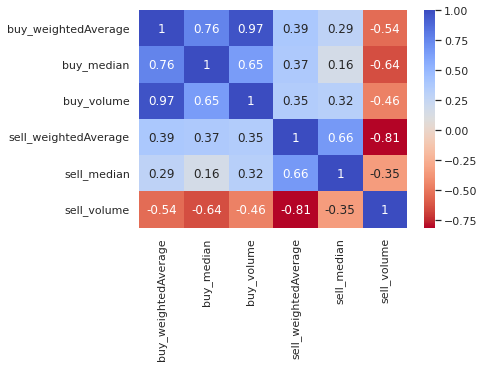

In [86]:
cols = ['buy_weightedAverage', 'buy_median', 'buy_volume', 'sell_weightedAverage', 'sell_median', 'sell_volume']
sns.heatmap(chiral_structures[cols].corr(), annot=True, cmap='coolwarm_r')

Time series plot with both median and averageWeight. Since we are working with data that is dependent on the time 

Command executed successfully
Command executed successfully


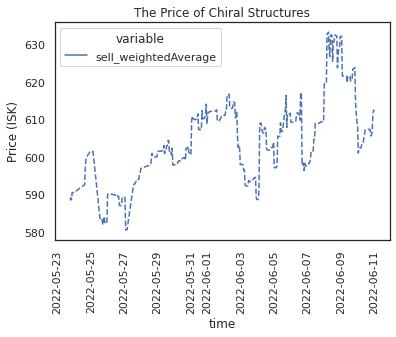

In [87]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
create_item_plot("Chiral Structures", "30000142")


In [88]:
# Return the current price of a material in all regions
def current_price(material_name: str, region_id: int | str = "all", order_type: str = "buy"):
    """_summary_

    Args:
        material_name (str): _description_
        region_id (int | str, optional): _description_. Defaults to "all".
        order_type (str, optional): _description_. Defaults to "buy".
    """
    
    item_id = api.get_item_id(material_name)
    
    command = (f"""
        SELECT data -> '{item_id}' -> '{order_type}'
        FROM market_data
        WHERE region_id = {region_id}
    """)
    
# Determine how much an item has increased by given a time frame
def compute_percentage_gain(material_name: str, region_id: str | int, order_type):
    pass

# Compute the weighted average since we want minimize the effect of unusually high or low material prices

# Create a class that computes various properties of a material throughout a certain period of time

## Data Preprocessing

First we need to check that the data is in chronological order and that the time stamps are equidstant in the time series. The chronological order can be achieved by sorting the dataframe by the timesamps.

In [89]:
# Sort values by timestamp (not necessary but making sure)
df = chiral_structures.sort_values(by='time')

# Checking time intervals

df['time_interval'] = df.time - df.time.shift(1)

df[['time', 'time_interval']]


,time,time_interval
0,2022-05-23 17:43:39.687705,NaT
1,2022-05-23 17:51:28.883474,0 days 00:07:49.195769
2,2022-05-23 17:53:37.915917,0 days 00:02:09.032443
3,2022-05-23 17:56:09.959608,0 days 00:02:32.043691
4,2022-05-23 18:00:37.138196,0 days 00:04:27.178588
...,...,...
393,2022-06-10 20:00:39.885346,0 days 00:59:59.791773
394,2022-06-10 21:00:39.246107,0 days 00:59:59.360761
395,2022-06-10 22:00:41.924547,0 days 01:00:02.678440
396,2022-06-10 23:00:40.779917,0 days 00:59:58.855370


In [90]:
chiral_structures = df[df.time > '2022-05-28'].copy()


## Time Series Characteristics

In this situation we have a single input and single output that we are interested in. Mainly the weighted sell price. Time series have characteristics such as...

- Trend and Level
- Seasonality
- Random / Noise

We will be exploring these characteristics using the statsmodels library.

In [91]:
def decomposition_of_timeseries(df: pd.DataFrame, cols: List):
    
    decompose_cols = cols

    for col in decompose_cols:
        decomp = seasonal_decompose(df[col], period=52, model='additive', extrapolate_trend='freq')
        df[f"{col}_trend"] = decomp.trend
        df[f"{col}_seasonal"] = decomp.seasonal

In [92]:
decomposition_of_timeseries(chiral_structures, ['buy_weightedAverage', 'sell_weightedAverage'])

chiral_structures

,time,buy_weightedAverage,buy_max,buy_min,buy_stddev,buy_median,buy_volume,buy_orderCount,buy_percentile,sell_weightedAverage,...,sell_stddev,sell_median,sell_volume,sell_orderCount,sell_percentile,time_interval,buy_weightedAverage_trend,buy_weightedAverage_seasonal,sell_weightedAverage_trend,sell_weightedAverage_seasonal
74,2022-05-28 00:00:07.322711,299.550672,498.0,5.53,171.431687,473.6,1337680.0,14,498.000000,596.981305,...,88.379446,610.0,4944499.0,28,545.000000,0 days 01:00:04.080996,353.931090,-29.540431,594.448844,-0.423796
75,2022-05-28 01:00:02.592959,299.550672,498.0,5.53,171.431687,473.6,1337680.0,14,498.000000,597.044459,...,88.379446,610.0,4938499.0,28,545.000000,0 days 00:59:55.270248,352.705095,-32.109503,594.632310,-0.034354
76,2022-05-28 02:00:05.091777,299.538803,498.0,5.53,171.431687,473.6,1337600.0,14,498.000000,597.104281,...,88.379446,610.0,4932829.0,28,545.000000,0 days 01:00:02.498818,351.479100,-32.752348,594.815775,2.375304
77,2022-05-28 03:00:02.812836,299.538803,498.0,5.53,171.431687,473.6,1337600.0,14,498.000000,597.231344,...,88.379446,610.0,4920829.0,28,545.000000,0 days 00:59:57.721059,350.253106,-17.559720,594.999241,1.680032
78,2022-05-28 04:00:02.833276,299.538803,498.0,5.53,171.431687,473.6,1337600.0,14,498.000000,597.231344,...,88.379446,610.0,4920829.0,28,545.000000,0 days 01:00:00.020440,349.027111,-19.093885,595.182707,2.131745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,2022-06-10 20:00:39.885346,361.431159,483.4,5.53,174.682577,476.1,2040170.0,13,483.335134,605.860707,...,71.094613,602.6,3221338.0,25,533.432961,0 days 00:59:59.791773,424.995504,-6.981430,621.058489,2.699872
394,2022-06-10 21:00:39.246107,361.727476,483.9,5.53,174.764581,476.1,2040170.0,13,483.835134,606.620336,...,71.094613,602.6,3187918.0,25,533.453225,0 days 00:59:59.360761,427.705218,-3.657801,621.084208,3.614361
395,2022-06-10 22:00:41.924547,360.275513,484.3,5.53,174.781987,476.1,2016170.0,13,483.858725,611.587769,...,70.412684,603.8,2985219.0,24,533.955122,0 days 01:00:02.678440,430.414933,-4.091606,621.109926,5.661669
396,2022-06-10 23:00:40.779917,359.665323,483.9,5.53,180.313858,473.6,2004330.0,12,483.900000,612.472574,...,69.460422,605.0,2951645.0,23,534.000000,0 days 00:59:58.855370,433.124648,-9.496997,621.135645,4.380489


In [93]:
df_plot = pd.melt(chiral_structures, ['time', 'buy_weightedAverage'])
df_plot

,time,buy_weightedAverage,variable,value
0,2022-05-28 00:00:07.322711,299.550672,buy_max,498.0
1,2022-05-28 01:00:02.592959,299.550672,buy_max,498.0
2,2022-05-28 02:00:05.091777,299.538803,buy_max,498.0
3,2022-05-28 03:00:02.812836,299.538803,buy_max,498.0
4,2022-05-28 04:00:02.833276,299.538803,buy_max,498.0
...,...,...,...,...
6475,2022-06-10 20:00:39.885346,361.431159,sell_weightedAverage_seasonal,2.699872
6476,2022-06-10 21:00:39.246107,361.727476,sell_weightedAverage_seasonal,3.614361
6477,2022-06-10 22:00:41.924547,360.275513,sell_weightedAverage_seasonal,5.661669
6478,2022-06-10 23:00:40.779917,359.665323,sell_weightedAverage_seasonal,4.380489


(array([19141., 19143., 19144., 19146., 19148., 19150., 19152., 19154.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

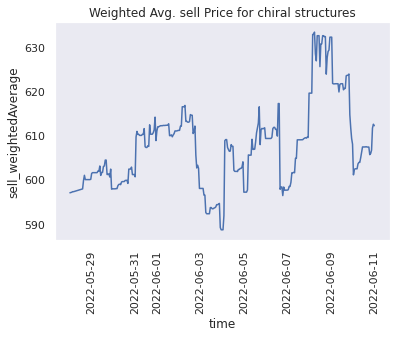

In [94]:
# Plotting
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_theme(style="dark")
fig = sns.lineplot(data=chiral_structures, x="time", y="sell_weightedAverage")
fig.set(title="Weighted Avg. sell Price for chiral structures")
plt.xticks(rotation=90)

(array([19141., 19143., 19144., 19146., 19148., 19150., 19152., 19154.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

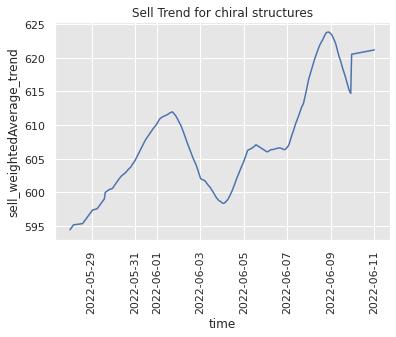

In [95]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig = sns.lineplot(data=chiral_structures, x="time", y="sell_weightedAverage_trend")
fig.set(title="Sell Trend for chiral structures")
plt.xticks(rotation=90)

(array([19141., 19143., 19144., 19146., 19148., 19150., 19152., 19154.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

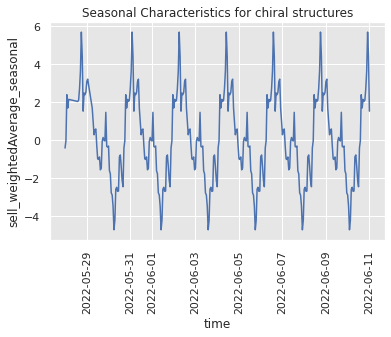

In [96]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig = sns.lineplot(data=chiral_structures, x="time", y="sell_weightedAverage_seasonal")
fig.set(title="Seasonal Characteristics for chiral structures")
plt.xticks(rotation=90)

There are three different methods to check for stationary:
- Visual plot of the rolling mean and variance
- Partition the time series into two partitions
- Dickey Fuller Test (Hypothesis testing)


(array([19141., 19143., 19144., 19146., 19148., 19150., 19152., 19154.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

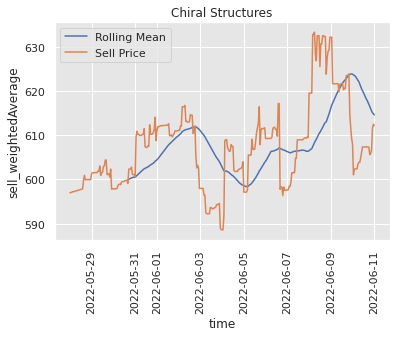

In [97]:
# Visualization of the rolling mean
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
rolling_window=52
fig = sns.lineplot(data=chiral_structures, x="time", y=chiral_structures["sell_weightedAverage"].rolling(52).mean(), label="Rolling Mean")
fig = sns.lineplot(data=chiral_structures, x="time", y=chiral_structures["sell_weightedAverage"], label="Sell Price")
fig.set(title="Chiral Structures")
plt.xticks(rotation=90)

From the visual plot of the rolling mean we can see that the sell price of Chiral Structures is not stationary. We can continue to see this using a hypothesis test and breaking the time series into two partitions.

In [122]:
num_partitions = 2
df = chiral_structures[['time', "sell_weightedAverage", "buy_weightedAverage", 'sell_median', 'buy_median', 'sell_volume', 'buy_volume']]
partition_length = int(len(df) / num_partitions)

partition1_mean = df.head(partition_length).mean()
partition1_var = df.head(partition_length).var()
partition2_mean = df.tail(partition_length).mean()
partition2_var = df.tail(partition_length).var()

/tmp/ipykernel_690584/1804524799.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  partition1_mean = df.head(partition_length).mean()
/tmp/ipykernel_690584/1804524799.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  partition1_var = df.head(partition_length).var()
/tmp/ipykernel_690584/1804524799.py:7: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  partition2_mean = df.tail(partition_length).mean()
/tmp/ipykernel_690584/1804524799.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns b

In [123]:
stationarity_test = pd.concat([partition1_mean, partition2_mean, partition1_var, partition2_var], axis=1)
stationarity_test.columns = ['Partition 1 Mean', 'Partition 2 Mean', 'Partition 1 Variance', 'Partition 2 Variance']

def highlight_greater(x):
    """ Highlights if partition is the same as the previous partition.
    
        Color:
            Salmon: Partition is similar means but not exact
            Green: Exactly the same mean or variance
            Gold: Vastly different means and variance 

    Args:
        x (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partition 1 Mean'] == temp['Partition 2 Mean'])
    m2 = (temp['Partition 1 Variance'] == temp['Partition 2 Variance'])
    m3 = (temp['Partition 1 Mean'] < temp['Partition 2 Mean']+3) & (temp['Partition 1 Mean'] > temp['Partition 2 Mean']-3)
    m4 = (temp['Partition 1 Variance'] < temp['Partition 2 Variance']+3) & (temp['Partition 1 Variance'] > temp['Partition 2 Variance']-3)

    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['Partition 1 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Mean'])

    df1['Partition 1 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Variance'])

    return df1


stationarity_test.style.apply(highlight_greater, axis=None).format("{:20,.0f}")

,Partition 1 Mean,Partition 2 Mean,Partition 1 Variance,Partition 2 Variance
sell_weightedAverage,604,612,51,104
buy_weightedAverage,308,275,"2,557","4,050"
sell_median,602,604,45,65
buy_median,466,465,154,103
sell_volume,"4,257,769","3,627,673","184,793,394,152","210,599,583,602"
buy_volume,"1,508,297","1,340,050","145,277,020,575","218,700,332,645"


From the table, sell_median and buy_median have almost the same mean in both partition 1 & 2 however the other features do not. We can also see that the sell volume has fallen quite a bit for chiral structures by roughly a quarter million. All of the features therefore are non stationary since the mean and variance is changing.

/home/salman1567/code/Data Science - Machine Learning Projects/Data Science Portfolio/Eve_Online_PI_Price_Forecaster/env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/salman1567/code/Data Science - Machine Learning Projects/Data Science Portfolio/Eve_Online_PI_Price_Forecaster/env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/salman1567/code/Data Science - Machine Learning Projects/Data Science 

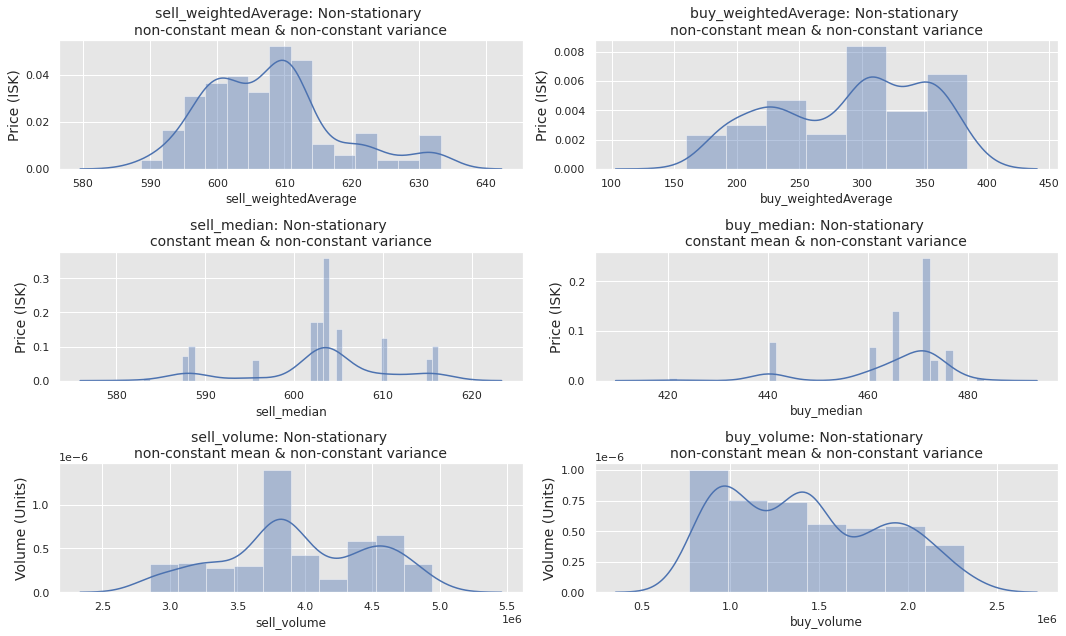

In [132]:
# Distribution Plots
# TODO: Fix deprecation warning

f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

sns.distplot(df['sell_weightedAverage'], ax=ax[0,0])
ax[0, 0].set_title('sell_weightedAverage: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Price (ISK)', fontsize=14)

sns.distplot(df['buy_weightedAverage'], ax=ax[0,1])
ax[0, 1].set_title('buy_weightedAverage: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 1].set_ylabel(ylabel='Price (ISK)', fontsize=14)

sns.distplot(df['sell_median'], ax=ax[1,0])
ax[1, 0].set_title('sell_median: Non-stationary \nconstant mean & non-constant variance', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Price (ISK)', fontsize=14)

sns.distplot(df['buy_median'], ax=ax[1,1])
ax[1, 1].set_title('buy_median: Non-stationary \nconstant mean & non-constant variance', fontsize=14)
ax[1, 1].set_ylabel(ylabel='Price (ISK)', fontsize=14)

sns.distplot(df['sell_volume'], ax=ax[2,0])
ax[2, 0].set_title('sell_volume: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[2, 0].set_ylabel(ylabel='Volume (Units)', fontsize=14)

sns.distplot(df['buy_volume'], ax=ax[2,1])
ax[2, 1].set_title('buy_volume: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[2, 1].set_ylabel(ylabel='Volume (Units)', fontsize=14)


plt.tight_layout()
plt.show()

We will be conducting an Augmented Dickey Fuller Test (Hypothesis test for stationary). The null hypothesis is that the time series is NOT stationary. Thus if our p-value is less than 0.05 we can reject our null hypothesis aka it is stationary.

## Modeling

### 1. Naive Approach

The naive approach is that the price will just be whatever the previous price was and it will be not change. 

### 2. Moving Average

### 3. Exponential Smoothing

### 4. Arima